# Text Classification using Siamese Neural Network

Siamese Neural Networks are type of neural networks that contain multiple instances of same model, share the same architecture and weights. This type of neural network works well when the training data is less and hence the concept of one shot learning and few shot learning comes into the picture which are concepts which utilize the siamese model architecture. 
The architecture of a general neural network is shown below. 

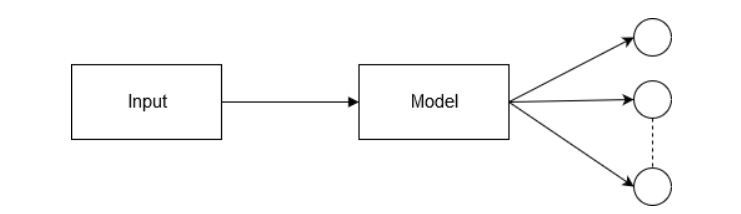

While a basic architecture of a Siamese model is shown below.

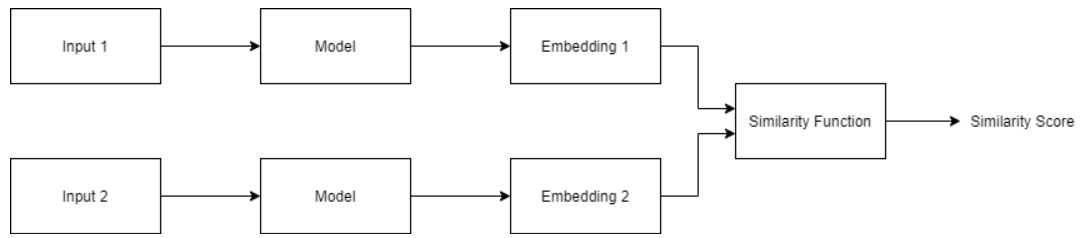

So in this case, although the data set is large enough to perform text classification using general neural netowrks, siamese is just used for information purposes and to see how different types of losses affect training and finally looking at the evaluation part.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv

from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [2]:
df = pd.read_csv('../input/nlp-getting-started/train.csv')
df.drop(['keyword', 'location', 'id'], axis=1, inplace=True)
display(df.sample(5))

,text,target
664,@BabySweet420 I'm mad 420 in your name &amp; y...,0
1197,Mmmmmm I'm burning.... I'm burning buildings I...,1
1078,@dopeitsval ahh you're bomb baby ??,0
5713,I have an unexplainable desire to watch The Re...,0
1970,Like a cyclone imperialism spins across the gl...,1


In [3]:
df.shape

(7613, 2)

In [4]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

# Data Cleaning

In [5]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [6]:
display(df.sample(2))

,text,target,clean_text
1550,Our Chemical Spill Cleanup videos will prepare...,1,chemical spill cleanup video prepare emergency...
5651,Coastal German Shepherd Rescue OC shared a lin...,0,coastal german shepherd rescue oc share link a...


# Contrastive Loss

## Data Preparation

In [7]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

# Selecting only 1000 samples for siamese model
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => label 1 if pairs from same class otherwise 0
df2 = pd.DataFrame(columns=['text1', 'text2', 'label'])

for data in disaster:
  data1 = data
  data2 = random.choice(disaster)
  data3 = random.choice(non_disaster)

  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]


for data in non_disaster:
  data1 = data
  data2 = random.choice(non_disaster)
  data3 = random.choice(disaster)
  
  df2.loc[len(df2)] = [data1, data2, 1]
  df2.loc[len(df2)] = [data1, data3, 0]

In [8]:
df2.shape

(4000, 3)

In [9]:
display(df2.sample(5))

,text1,text2,label
3312,louis vuitton monogram sophie limited edition ...,photo bath body work cosmetic bag periwinkle b...,1
3282,thing pick tozlet seat butt leprosy fullblown ...,men cross body canvas waist pack solid letter ...,1
1186,ok peace hope fall cliff along dignity,9 mile backup i77 southaccident block right 2 ...,1
87,accident property damage piner rdhorndale dr,stavernise france agree repay russia two warsh...,0
2663,really happen take king story trailer space ba...,binellithresa ty follow go brutally abuseddeso...,0


## Data Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(df2[['text1', 'text2']], df2['label'], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(3200, 2) (800, 2) (3200,) (800,)


In [11]:
X_train['text'] = X_train[['text1', 'text2']].apply(lambda x: str(x[0])+" "+str(x[1]), axis=1)

## Glove Embeddings

In [12]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['text1'] = X_train['text1'].astype(str)
X_train['text2'] = X_train['text2'].astype(str)
X_val['text1'] = X_val['text1'].astype(str)
X_val['text2'] = X_val['text2'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['text1'].values)
train_q2_seq = t.texts_to_sequences(X_train['text2'].values)
val_q1_seq = t.texts_to_sequences(X_val['text1'].values)
val_q2_seq = t.texts_to_sequences(X_val['text2'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')

In [13]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open('../input/glove6b300dtxt/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [15]:
print(embedding_matrix.shape)

(6126, 300)


## Siamese Model

In [16]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [17]:
def build_network():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network

In [18]:
input_1 = Input(shape=(train_q1_seq.shape[1],))
input_2 = Input(shape=(train_q2_seq.shape[1],))

network = build_network()

encoded_input_1 = network(input_1)
encoded_input_2 = network(input_2)

distance = Lambda(euclidean_distance)([encoded_input_1, encoded_input_2])

# Connect the inputs with the outputs
model = Model([input_1, input_2], distance)

model.compile(loss=contrastive_loss, optimizer=Adam(0.001))

In [19]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

In [20]:
model.fit([train_q1_seq,train_q2_seq],y_train.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq],y_val.reshape(-1,1)))

Epoch 1/5
50/50 [==============================] - 18s 309ms/step - loss: 0.4609 - val_loss: 0.2783
Epoch 2/5
50/50 [==============================] - 14s 281ms/step - loss: 0.2303 - val_loss: 0.2488
Epoch 3/5
50/50 [==============================] - 14s 284ms/step - loss: 0.1661 - val_loss: 0.2225
Epoch 4/5
50/50 [==============================] - 14s 284ms/step - loss: 0.1251 - val_loss: 0.1815
Epoch 5/5
50/50 [==============================] - 14s 279ms/step - loss: 0.1004 - val_loss: 0.1602


In [21]:
# Save model for further use
# serialize model to JSON
model_json = model.to_json()
with open("siamesemodel-contrastive-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-contrastive-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-contrastive-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-contrastive-loss.h5")
# print("Loaded model from disk")

Saved model to disk


## Prediction

### Non Disaster Tweet

In [22]:
non_disaster_initial[122]

'stormbeard steellord see juda priest 2005 rob come back scorpion support fuck annihilated place astonish gig'

In [23]:
prediction_data = "usdjpy despite richter scale overbought fxstreet line swissquote bullish long jason sen mr ambulance chaser b…"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.00936033]], dtype=float32)

In [24]:
prediction_data = "usdjpy despite richter scale overbought fxstreet line swissquote bullish long jason sen mr ambulance chaser b…"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = non_disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.00181365]], dtype=float32)

### Disaster Tweet

In [25]:
disaster_initial[12]

'rain flood florida tampabay tampa 18 19 day ive lose count'

In [26]:
prediction_data = "cameroon bir soldier 05012020 invaded southerncameroons village kimar set ablaze total of"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.01153654]], dtype=float32)

In [27]:
prediction_data = "cameroon bir soldier 05012020 invaded southerncameroons village kimar set ablaze total of"
prediction_vector = t.texts_to_sequences([prediction_data])
prediction_vector = pad_sequences(prediction_vector,maxlen=200)

assistant_data = non_disaster[11]
assistant_vector = t.texts_to_sequences([assistant_data])
assistant_vector = pad_sequences(assistant_vector,maxlen=200)

model.predict([prediction_vector, assistant_vector])

array([[0.00398989]], dtype=float32)

# Triplet Loss

## Data Preparation

In [28]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

# Taking 1000 samples from the entire data
disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in disaster:
  a = data
  p = random.choice(disaster)
  n = random.choice(non_disaster)

  df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in non_disaster:
  a = data
  p = random.choice(non_disaster)
  n = random.choice(disaster)
  
  df2.loc[len(df2)] = [a, p, n, 1, 0]

In [29]:
df2.shape

(2000, 5)

In [30]:
display(df2.sample(5))

,Anchor,Positive,Negative,label,class
1030,santa cruz ûó head st elizabeth police superi...,fuck neil go fall cliff somethingyr,unexercised honda rundown neighborhood desolat...,1,0
932,service green line resume earlier derailment n...,photo green line derailment near cottage grove...,320 ir icemoon aftershock djicemoon dubstep tr...,1,1
1951,chemical brother play armory sf tomorrow night...,armageddon avert el patron ultimalucha,militant attack police post udhampur 2 spos in...,1,0
908,jozerphine literally look yeah derailed smiths...,pt crosssectarian protest powerful shia cleric...,u national park service tonto national forest ...,1,1
1404,real vibez radio blaze best vibez nowplaying l...,s3xleak ph0tos 19yrs old ashwo lady festac tow...,i77 mile marker 31 40 south mooresville iredel...,1,0


## Data Split

In [31]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1280, 3) (320, 3) (400, 3) (1280, 2) (320, 2) (400, 2)


In [32]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

## Glove Embeddings

In [33]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

In [34]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open('../input/glove6b300dtxt/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [36]:
print(embedding_matrix.shape)

(5743, 300)


## Siamese Model

In [37]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [38]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network


def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = Adam(0.001))
  return model

In [39]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 2)            3455126     input_3[0][0]                    
                                                                 input_4[0][0]              

In [40]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [41]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Epoch 1/5
20/20 [==============================] - 11s 442ms/step - loss: 0.3569 - val_loss: 0.1842
Epoch 2/5
20/20 [==============================] - 8s 419ms/step - loss: 0.1578 - val_loss: 0.1488
Epoch 3/5
20/20 [==============================] - 8s 410ms/step - loss: 0.1037 - val_loss: 0.1422
Epoch 4/5
20/20 [==============================] - 8s 423ms/step - loss: 0.0770 - val_loss: 0.1394
Epoch 5/5
20/20 [==============================] - 8s 411ms/step - loss: 0.0568 - val_loss: 0.1521


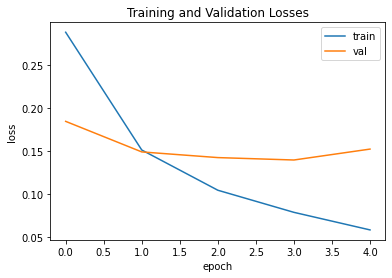

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [43]:
# Save model for further use
# serialize model to JSON
model_json = model.to_json()
with open("siamesemodel-triplet-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-triplet-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-triplet-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-triplet-loss.h5")
# print("Loaded model from disk")

Saved model to disk


## Evaluation

In [44]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

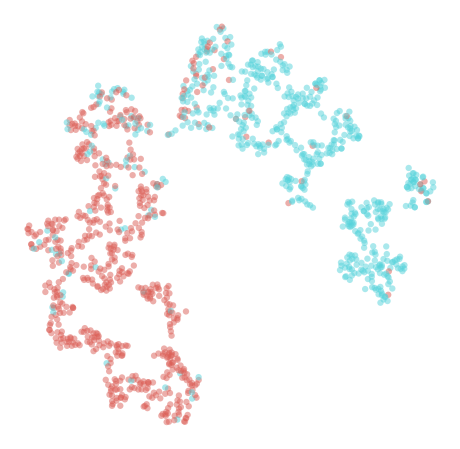

In [45]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [46]:
# classifier that computes the class of a specific embedding for prediction purposes
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = np_utils.to_categorical(y_train_class, 2)
Y_test_onehot = np_utils.to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=5)

Epoch 1/5
40/40 [==============================] - 1s 7ms/step - loss: 0.7370 - accuracy: 0.4812 - val_loss: 0.7131 - val_accuracy: 0.5250
Epoch 2/5
40/40 [==============================] - 0s 3ms/step - loss: 0.7183 - accuracy: 0.4724 - val_loss: 0.6963 - val_accuracy: 0.5425
Epoch 3/5
40/40 [==============================] - 0s 3ms/step - loss: 0.6867 - accuracy: 0.5329 - val_loss: 0.6821 - val_accuracy: 0.5925
Epoch 4/5
40/40 [==============================] - 0s 3ms/step - loss: 0.6740 - accuracy: 0.5922 - val_loss: 0.6689 - val_accuracy: 0.6475
Epoch 5/5
40/40 [==============================] - 0s 3ms/step - loss: 0.6537 - accuracy: 0.7010 - val_loss: 0.6570 - val_accuracy: 0.7000


## Prediction

In [47]:
input = X_test_eval[:10]
prediction = classifier_model.predict(input)
print(prediction)

[[0.49569252 0.50430745]
 [0.6872284  0.3127716 ]
 [0.61646354 0.3835364 ]
 [0.49609348 0.5039065 ]
 [0.5593777  0.44062236]
 [0.50903314 0.4909669 ]
 [0.54182243 0.4581775 ]
 [0.52215576 0.4778442 ]
 [0.47024143 0.5297586 ]
 [0.44645578 0.5535442 ]]
